### Steam
課程：社群媒體分析

授課教授：黃三益老師

組別：Group_7

組員：

B104020019 黃婕妮

B104020023 蔡宜樺

M134020005 馮祐倫

M134020021 李翊曲

M134020030 戴廣琛

M134020046 宋旻家

M134610017 李逸華


大綱


1. 資料介紹

   1.1 資料來源

   1.2 分析動機&目的

2. 資料前處理

   2.1 資料匯入

   2.2 資料清理

   2.3 斷句斷詞

   2.4 停用字處理

   2.5 計算詞頻

   2.6 文字雲

3. 情緒分析
4. 進階情緒分析

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import matplotlib.font_manager as fm
from wordcloud import WordCloud

from collections import Counter

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

### **2. 資料清理**

2.1 資料匯入

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## 讀取從steam上面爬下來的評論資料
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/english.csv')
# df = pd.read_csv('data/english.csv')
df

,isRecommended,isHelpful,Content,Date
0,不推薦,"3,743 個人認為這篇評論值得參考\n125 個人認為這篇評論很有趣 170",張貼於：2024 年 7 月 8 日\n2 10 dollar battle passes ...,張貼於：2024 年 7 月 8 日
1,不推薦,"4,345 個人認為這篇評論值得參考\n84 個人認為這篇評論很有趣 185",張貼於：2024 年 7 月 8 日\nNow with the new battle pa...,張貼於：2024 年 7 月 8 日
2,不推薦,"1,174 個人認為這篇評論值得參考\n18 個人認為這篇評論很有趣 5",張貼於：2024 年 6 月 27 日\nGame freezes every sessio...,張貼於：2024 年 6 月 27 日
3,不推薦,"2,057 個人認為這篇評論值得參考\n81 個人認為這篇評論很有趣 208",張貼於：2024 年 10 月 31 日\nWe don't have a cheater ...,張貼於：2024 年 10 月 31 日
4,不推薦,"1,445 個人認為這篇評論值得參考\n27 個人認為這篇評論很有趣 240",張貼於：2024 年 10 月 8 日\nI've got nearly 3k hours ...,張貼於：2024 年 10 月 8 日
...,...,...,...,...
4313,不推薦,1 個人認為這篇評論值得參考 0,張貼於：1 月 23 日\ni,張貼於：1 月 23 日
4314,不推薦,1 個人認為這篇評論值得參考 0,張貼於：1 月 22 日\nAs pewdiepie once said on a brid...,張貼於：1 月 22 日
4315,推薦,1 個人認為這篇評論值得參考 1,張貼於：1 月 22 日\nyes,張貼於：1 月 22 日
4316,不推薦,1 個人認為這篇評論值得參考 0,張貼於：1 月 24 日\nPlayed over 1000 hours with this...,張貼於：1 月 24 日


2.2 資料清理

*   統一日期格式：將 Date 欄位轉換為 20xx-xx-xx 格式。
*   移除評論中的日期資訊：刪除 Content 欄位內的日期字樣。
*   處理IsHelpful欄位：移除空值，提取數值，轉為 int。
*   篩選英文評論：保留只含英文字母、數字、空格、標點的內容。
*   刪除過短評論：只保留內容超過一個單字的評論。

In [5]:
#清理資料並統一格式
def data_cleaned(origin):
    ##將日期改為20xx-xx-xx
    origin["Date"] = origin["Date"].str.replace(r"張貼於：(\d{4}) 年 (\d{1,2}) 月 (\d{1,2}) 日", r"\1-\2-\3", regex=True)
    origin["Date"] = origin["Date"].str.replace(r"張貼於：(\d{1,2}) 月 (\d{1,2}) 日", r"2025-\1-\2", regex=True)

    ##去除評論中包含日期的部分
    origin["Content"] = origin["Content"].str.replace(r"張貼於：(\d{4}) 年 (\d{1,2}) 月 (\d{1,2}) 日\n", r"", regex=True)
    origin["Content"] = origin["Content"].str.replace(r"張貼於：(\d{1,2}) 月 (\d{1,2}) 日\n", r"", regex=True)

    ##去掉isHelpful為空值的資料，用isUseful作為新的欄位，代表有多少人覺得這篇評論有參考性
    origin = origin.dropna(subset=['isHelpful'])
    origin["isUseful"] = origin["isHelpful"].str.extract(r"([\d,]+) 個人認為這篇評論值得參考")[0].str.replace(",", "").astype(int)
    origin = origin.drop(["isHelpful"], axis=1)

    ##僅留下英文的評論
    origin = origin[origin['Content'].str.match(r'^[A-Za-z0-9\s.,!?\'"-]*$', na=False)]# 保留只包含英文字符（字母、數字、空格和標點）的行

    ##去除只有一個單字的資料
    origin = origin[origin['Content'].str.split().str.len()>1]

    return origin

In [6]:
df = data_cleaned(df)

for_m134020005_df = df

df

,isRecommended,Content,Date,isUseful
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743
1,不推薦,"Now with the new battle pass system, I'm delet...",2024-7-8,4345
2,不推薦,Game freezes every session i play with the new...,2024-6-27,1174
8,不推薦,"Apex is like your neighbor's sister, she treat...",2024-7-18,330
10,不推薦,It's very sad. It's like saying good bye to a ...,2025-1-3,473
...,...,...,...,...
4309,推薦,Game needs new Devs. Slowly losing the communi...,2025-1-24,1
4311,不推薦,I found out I had 115 hours in this game and a...,2025-1-23,1
4312,推薦,GOOD GAME,2025-1-23,1
4314,不推薦,As pewdiepie once said on a bridge.....,2025-1-22,1


2.3 斷句斷詞


*   清理文本：在 Content 欄位新增 sentence 欄位，將換行符'\n'取代為','。且移除 sentence 中的非字母、數字和空格字符。
*   斷詞：使用 NLTK 的 word_tokenize 進行斷詞，將 DataFrame 轉換為「一行對應一個詞」的格式。並轉換單詞為小寫。
*   詞幹提取：使用 Porter Stemmer 進行詞幹提取，將 word 欄位轉換為詞幹 (stem_token)。



In [7]:
import re
#新增['sentence']欄位，用'.'取代'\n'
df['sentence'] = df['Content'].str.replace(r'\n','.', regex=True)
##保留字母、數字和空格
df["sentence"] = df["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', x))

In [8]:
df

,isRecommended,Content,Date,isUseful,sentence
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...
1,不推薦,"Now with the new battle pass system, I'm delet...",2024-7-8,4345,Now with the new battle pass system Im deletin...
2,不推薦,Game freezes every session i play with the new...,2024-6-27,1174,Game freezes every session i play with the new...
8,不推薦,"Apex is like your neighbor's sister, she treat...",2024-7-18,330,Apex is like your neighbors sister she treats ...
10,不推薦,It's very sad. It's like saying good bye to a ...,2025-1-3,473,Its very sad Its like saying good bye to a lon...
...,...,...,...,...,...
4309,推薦,Game needs new Devs. Slowly losing the communi...,2025-1-24,1,Game needs new Devs Slowly losing the communit...
4311,不推薦,I found out I had 115 hours in this game and a...,2025-1-23,1,I found out I had 115 hours in this game and a...
4312,推薦,GOOD GAME,2025-1-23,1,GOOD GAME
4314,不推薦,As pewdiepie once said on a bridge.....,2025-1-22,1,As pewdiepie once said on a bridge


In [9]:
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

##使用NLTK的斷詞函式word_tokenize進行斷詞，將DataFrame處理成一個row一個斷詞的結果
df = df.assign(token = df['sentence'].apply(nltk.word_tokenize)).explode('token')
##轉小寫
df = df.assign(word = df['token'].str.lower())

df

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


,isRecommended,Content,Date,isUseful,sentence,token,word
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2,2
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,10,10
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,battle,battle
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,passes,passes
...,...,...,...,...,...,...,...
4316,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,name,name
4316,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,EA,ea
4316,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,is,is
4316,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,not,not


In [10]:
porter = PorterStemmer()

##將資料使用字根的方式表達
df['word'] = df['word'].astype(str)
df = df.assign(stem_token = df['word'].apply(porter.stem)).reset_index(drop=True)

df

,isRecommended,Content,Date,isUseful,sentence,token,word,stem_token
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2,2,2
1,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,10,10,10
2,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar,dollar
3,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,battle,battle,battl
4,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,passes,passes,pass
...,...,...,...,...,...,...,...,...
59531,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,name,name,name
59532,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,EA,ea,ea
59533,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,is,is,is
59534,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,not,not,not


2.4 停用字處理

In [11]:
# 下載停用詞資料
nltk.download('stopwords')

# 取得英文停用詞列表
stop_words = stopwords.words('english')

# 保留不是停用詞的行
df = df[~df['stem_token'].astype(str).str.lower().isin(stop_words)]

df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,isRecommended,Content,Date,isUseful,sentence,token,word,stem_token
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2,2,2
1,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,10,10,10
2,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar,dollar
3,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,battle,battle,battl
4,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,passes,passes,pass
...,...,...,...,...,...,...,...,...
59524,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,loyal,loyal,loyal
59525,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,player,player,player
59527,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,bans,bans,ban
59531,不推薦,Played over 1000 hours with this game in total...,2025-1-24,1,Played over 1000 hours with this game in total...,name,name,name


2.5 計算詞頻
*   使用 Counter 計算 stem_token（詞幹）欄位中每個詞出現的次數。
*   將詞頻計數結果轉換為 DataFrame，包含 stem_token（單字）和 frequency（詞頻），並按頻率排序。
*   輸出出現次數最高的前 10 個單字。
*   繪製前 10 個詞幹的詞頻長條圖，並將 Y 軸反轉，使詞頻最高的詞排在最上方。

In [12]:
# 以 df['word'] 欄位計算
word_counts = Counter(df['stem_token'].astype(str))

# 轉換為 DataFrame 方便查看
word_freq_df = pd.DataFrame(word_counts.items(), columns=['stem_token', 'frequency']).sort_values(by='frequency', ascending=False)

print(word_freq_df.head(10))  # 顯示前 10 個詞頻最高的單字


     stem_token  frequency
14         game       1940
8           thi       1096
1092      crash        688
21         play        646
115          ea        467
426       linux        381
16       player        318
269       money        295
122     cheater        290
140        dont        268


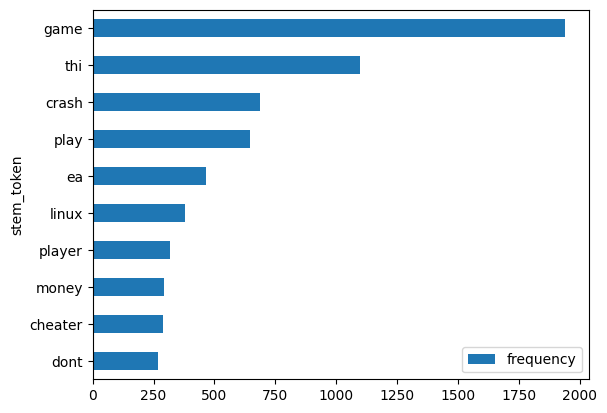

In [13]:
# 繪製詞頻為前10高的長條圖
word_freq_df.head(10).plot.barh(x = 'stem_token', y = 'frequency').invert_yaxis()
plt.show()

2.6 文字雲


*   將 stem_token 欄位的詞彙合併成一個大文本，並透過 WordCloud 產生文字雲來視覺化詞頻。
*   自訂停用詞（如 "game"、"play" 等），並擴充至 stop_words 列表，以排除無意義的高頻詞。
*   只保留不在停用詞列表內的詞彙，重新計算詞頻，並與最初的詞頻結果進行對比，觀察哪些詞彙被移除



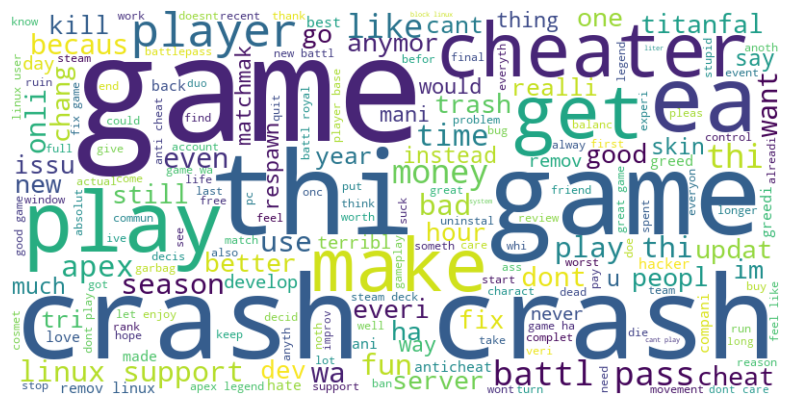

In [14]:
# 以 df['word'] 欄位繪製
text = ' '.join(df['stem_token'].dropna())  # 合併所有單字

# 產生文字雲
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(text)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # 移除座標軸
plt.show()


In [15]:
# 手動加入停用字
newStops = ['thi','game','play', 'playing','played', 'even', 'also', 'one', 'still', 'could', 'player', 'much', 'support']
stop_words.extend(newStops)

In [16]:
new_df = df[~df['stem_token'].isin(stop_words)]
df.head(15)

,isRecommended,Content,Date,isUseful,sentence,token,word,stem_token
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,2,2,2
1,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,10,10,10
2,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar,dollar
3,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,battle,battle,battl
4,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,passes,passes,pass
5,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,per,per,per
6,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,seasonTitanfall,seasontitanfall,seasontitanfal
7,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,died,died,die
9,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,this,this,thi
10,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,slop,slop,slop


In [17]:
new_freq_df = pd.DataFrame(new_df['stem_token'].value_counts())
new_freq_df = new_freq_df.reset_index()
new_freq_df.columns = ['word', 'freq']
new_freq_df.head(15)

,word,freq
0,crash,688
1,ea,467
2,linux,381
3,money,295
4,cheater,290
5,get,268
6,dont,268
7,apex,267
8,battl,249
9,like,238


In [18]:
# 第一次的詞頻圖
word_freq_df.head(15)

,stem_token,frequency
14,game,1940
8,thi,1096
1092,crash,688
21,play,646
115,ea,467
426,linux,381
16,player,318
269,money,295
122,cheater,290
140,dont,268


和第一次的詞頻相比，可以看到手動新增的停用詞被清掉了

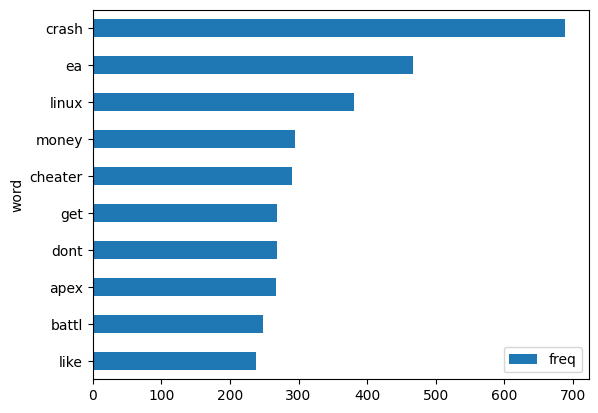

In [19]:
# 重新繪製詞頻為前10高的長條圖
new_freq_df.head(10).plot.barh(x = 'word', y = 'freq').invert_yaxis()
plt.show()

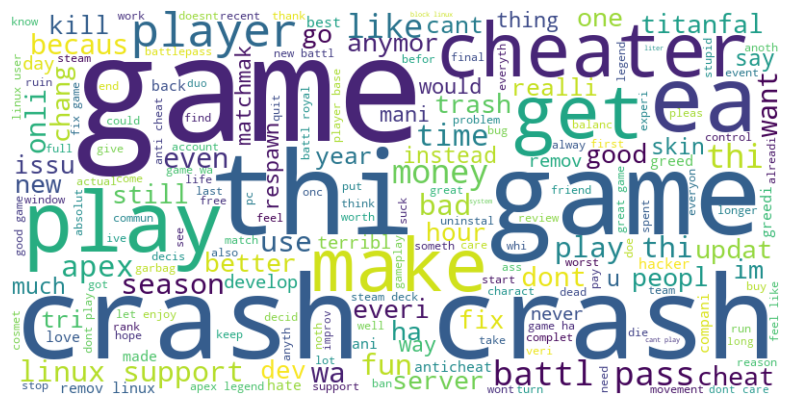

In [20]:
# 以 df['word'] 欄位繪製
text = ' '.join(new_df['stem_token'].dropna())  # 合併所有單字

# 產生文字雲
wordcloud_after_stop = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(text)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # 移除座標軸
plt.show()


c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20572 (\N{CJK UNIFIED IDEOGRAPH-505C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDE

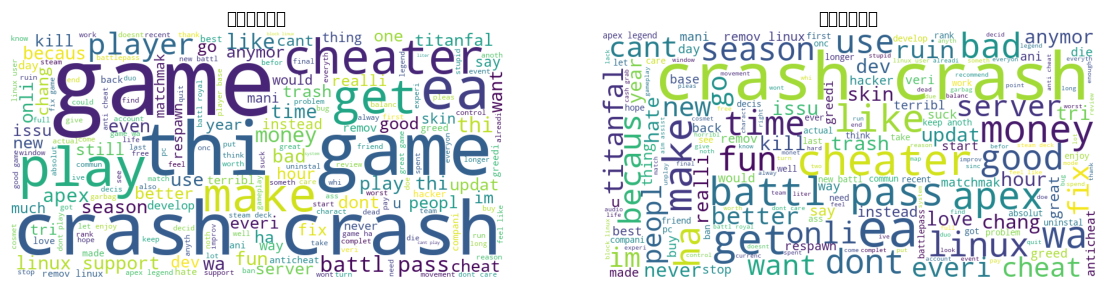

In [21]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("去除停用字前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after_stop)
plt.axis('off')
plt.title("去除停用字後")

plt.show()

### 情緒分析

In [22]:
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("punkt")
%matplotlib inline

plt.rcParams['figure.figsize'] =[6, 4]
plt.rcParams['figure.dpi'] = 150

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


讀取字典

In [ ]:
# liwc_dict = pd.read_csv('data/LIWC_EN.csv')
liwc_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/LIWC_EN.csv')
liwc_dict = liwc_dict.rename(columns={'name':'word', 'class':'sentiments'})
liwc_dict.head(10)

,word,sentiments
0,(:,affect
1,):,affect
2,:(,affect
3,:),affect
4,abandon,affect
5,abuse,affect
6,abusi,affect
7,accept,affect
8,accepta,affect
9,accepted,affect


讀取以斷辭好的資料

看看斷辭好後的資料筆數

In [25]:

df = new_df
num_unique_values = df['Content'].nunique()
print(f"Number of unique values in 'Content': {num_unique_values}")
# Number of unique values in 'Content': 1818

Number of unique values in 'Content': 2533


In [26]:
# 確認Date 欄位型態
# result: str
type(df['Date'][0])

str

In [27]:
# 將'Date'欄位變成時間
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# 新增 'Month' 欄位，連年一起留下以確保時間序正確]，連年一起留下以確保時間序正確]
df['Month'] = df['Date'].dt.strftime('%Y-%m')

C:\Users\vince\AppData\Local\Temp\ipykernel_4288\1175640718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\1175640718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.strftime('%Y-%m')


將情緒字典與斷詞結果進行合併

In [28]:
comment_liwc_df = pd.merge(df, liwc_dict, how = 'left')
comment_liwc_df.head()

,isRecommended,Content,Date,isUseful,sentence,token,word,stem_token,Month,sentiments
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07-08,3743,2 10 dollar battle passes per seasonTitanfall ...,2,2,2,2024-07,NaN
1,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07-08,3743,2 10 dollar battle passes per seasonTitanfall ...,10,10,10,2024-07,NaN
2,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07-08,3743,2 10 dollar battle passes per seasonTitanfall ...,dollar,dollar,dollar,2024-07,NaN
3,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07-08,3743,2 10 dollar battle passes per seasonTitanfall ...,battle,battle,battl,2024-07,NaN
4,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-07-08,3743,2 10 dollar battle passes per seasonTitanfall ...,passes,passes,pass,2024-07,NaN


In [29]:
# 查看每個章節的情緒字數量
sentiment_count = pd.DataFrame(comment_liwc_df.groupby(['Month', 'sentiments']).size()).reset_index()
mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count.head(10)

,Month,sentiments,size
3,2024-03,negative,32
4,2024-03,positive,34
8,2024-04,negative,50
9,2024-04,positive,44
14,2024-05,negative,51
15,2024-05,positive,70
20,2024-06,negative,34
21,2024-06,positive,39
26,2024-07,negative,577
27,2024-07,positive,676


In [30]:
# 分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
pos.head()

,Month,sentiments,size
4,2024-03,positive,34
9,2024-04,positive,44
15,2024-05,positive,70
21,2024-06,positive,39
27,2024-07,positive,676


In [31]:
neg.head(10)

,Month,sentiments,size
3,2024-03,negative,32
8,2024-04,negative,50
14,2024-05,negative,51
20,2024-06,negative,34
26,2024-07,negative,577
32,2024-08,negative,143
38,2024-09,negative,56
44,2024-10,negative,53
50,2024-11,negative,237
55,2024-12,negative,26


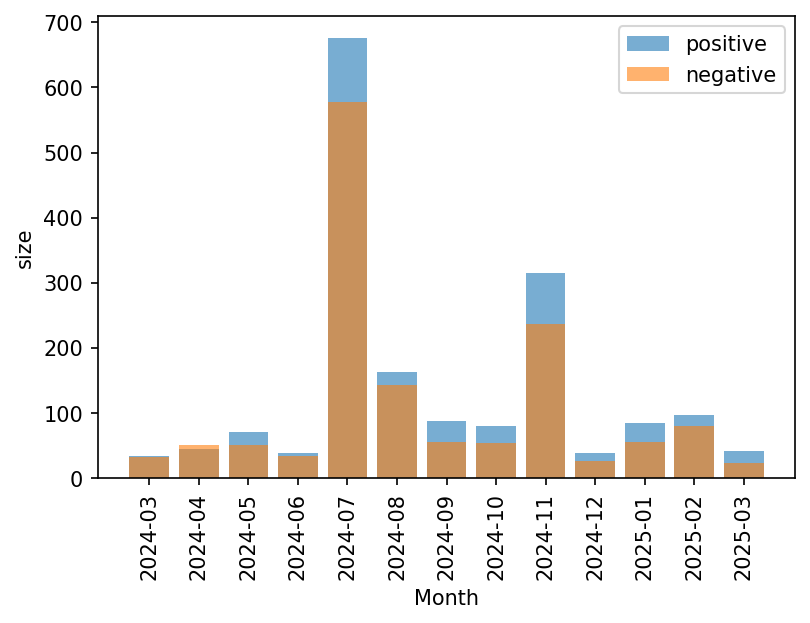

In [32]:
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['Month'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['Month'],
       neg['size'],
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('Month')
plt.ylabel('size')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)

ax.legend(['positive','negative'], loc ='upper right')
plt.show()

In [33]:
#計算正負情緒占比
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("Month")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head()

,Month,sentiments,size,ratio
3,2024-03,negative,32,0.484848
4,2024-03,positive,34,0.515152
8,2024-04,negative,50,0.531915
9,2024-04,positive,44,0.468085
14,2024-05,negative,51,0.421488


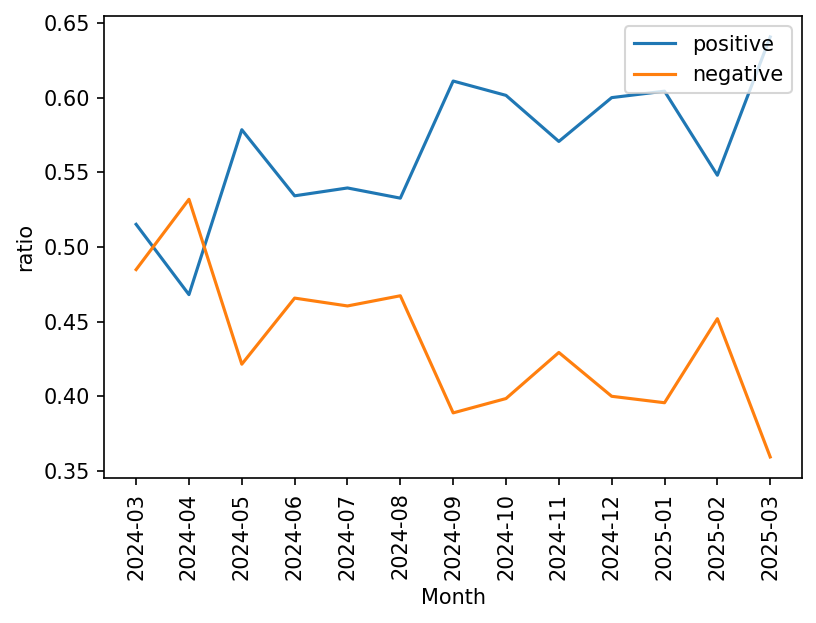

In [34]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
fig, ax = plt.subplots()

ax.plot(pos['Month'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['Month'],
       neg['ratio'],
       color = colors[1])
plt.xlabel('Month')
plt.ylabel('ratio')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)

ax.legend(['positive','negative'], loc ='upper right')

In [35]:
#列出各頻論正負辭出現次數
mask = ~comment_liwc_df['sentiments'].isna()
comment_sentiment_value = sentiment_count.pivot_table(index='Month', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
comment_sentiment_value.head()

,Month,negative,positive
0,2024-03,32.0,34.0
1,2024-04,50.0,44.0
2,2024-05,51.0,70.0
3,2024-06,34.0,39.0
4,2024-07,577.0,676.0


In [36]:
# sentiment 計算方式: positive - anger - anx - negative - sad
comment_sentiment_value["sentiment_value"] = (
    comment_sentiment_value["positive"]
    - comment_sentiment_value["negative"]
)
comment_sentiment_value.head()

,Month,negative,positive,sentiment_value
0,2024-03,32.0,34.0,2.0
1,2024-04,50.0,44.0,-6.0
2,2024-05,51.0,70.0,19.0
3,2024-06,34.0,39.0,5.0
4,2024-07,577.0,676.0,99.0


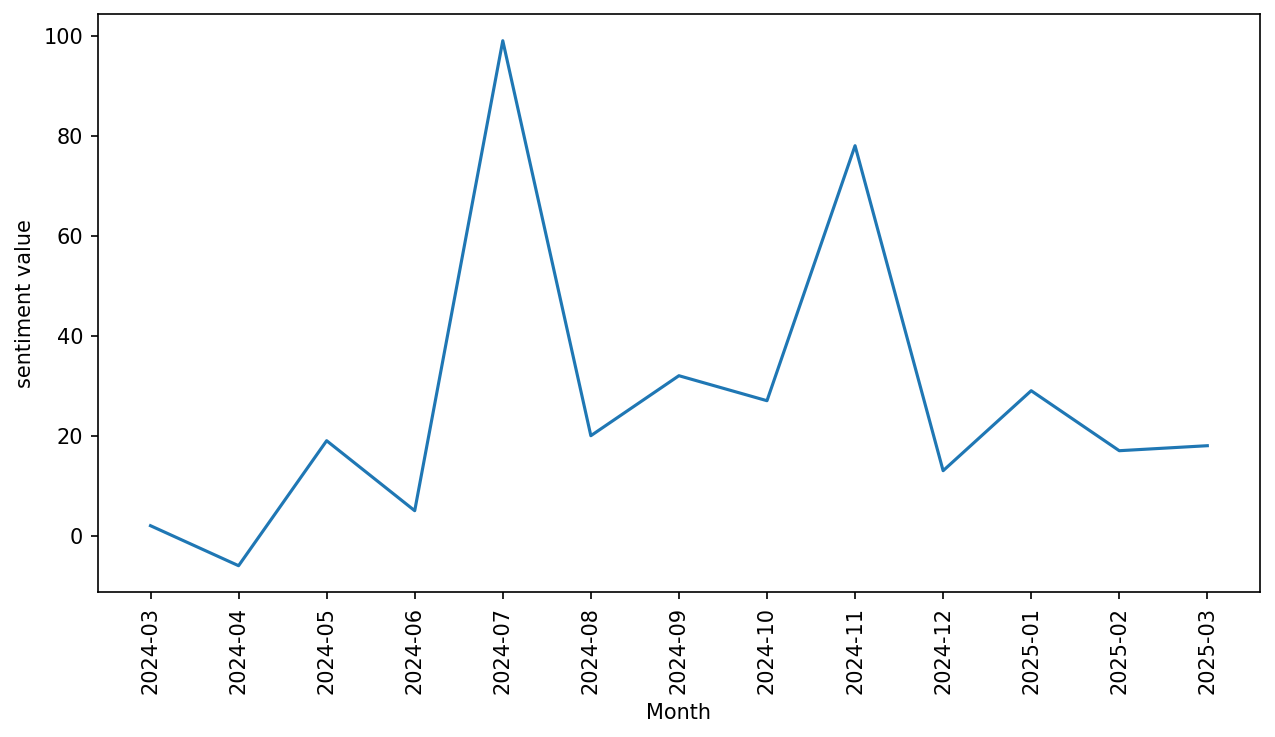

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
ax.plot(comment_sentiment_value['Month'], comment_sentiment_value["sentiment_value"])
ax.set_xlabel('Month')
ax.set_ylabel('sentiment value')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.show()

In [38]:
# 先看看情緒分數最低的章節
comment_sentiment_value.sort_values("sentiment_value", ascending=True)
# 2024-4

,Month,negative,positive,sentiment_value
1,2024-04,50.0,44.0,-6.0
0,2024-03,32.0,34.0,2.0
3,2024-06,34.0,39.0,5.0
9,2024-12,26.0,39.0,13.0
11,2025-02,80.0,97.0,17.0
12,2025-03,23.0,41.0,18.0
2,2024-05,51.0,70.0,19.0
5,2024-08,143.0,163.0,20.0
7,2024-10,53.0,80.0,27.0
10,2025-01,55.0,84.0,29.0


In [39]:
## 篩選出 2024年4月評論且負向情緒的詞彙
mask = (comment_liwc_df['Month']== '2024-04') & (comment_liwc_df['sentiments']=='negative')
comment_tf_by_ch_df = comment_liwc_df.loc[mask]
comment_tf_by_ch_df.head()

,isRecommended,Content,Date,isUseful,sentence,token,word,stem_token,Month,sentiments
288,推薦,I hate myself for playing this game.,2024-04-28,134,I hate myself for playing this game,hate,hate,hate,2024-04,negative
1617,不推薦,Thhe aprile took all my final fantasy skins i ...,2024-04-03,15,Thhe aprile took all my final fantasy skins i ...,lowered,lowered,lower,2024-04,negative
2052,不推薦,"Don't do it. The community is toxic, the game ...",2024-04-11,14,Dont do it The community is toxic the game is ...,sucks,sucks,suck,2024-04,negative
3858,推薦,"""piss off scablander""",2024-04-25,4,piss off scablander,piss,piss,piss,2024-04,negative
4141,不推薦,If you want to feel worse than you did before ...,2024-04-07,7,If you want to feel worse than you did before ...,worse,worse,wors,2024-04,negative


情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [40]:
word_count = comment_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False).head(15)

,word,sentiments,size
274,good,positive,212
273,good,affect,212
260,fun,positive,167
259,fun,affect,167
55,bad,negative,150
54,bad,affect,150
87,care,positive,95
86,care,affect,95
67,best,positive,93
66,best,affect,93


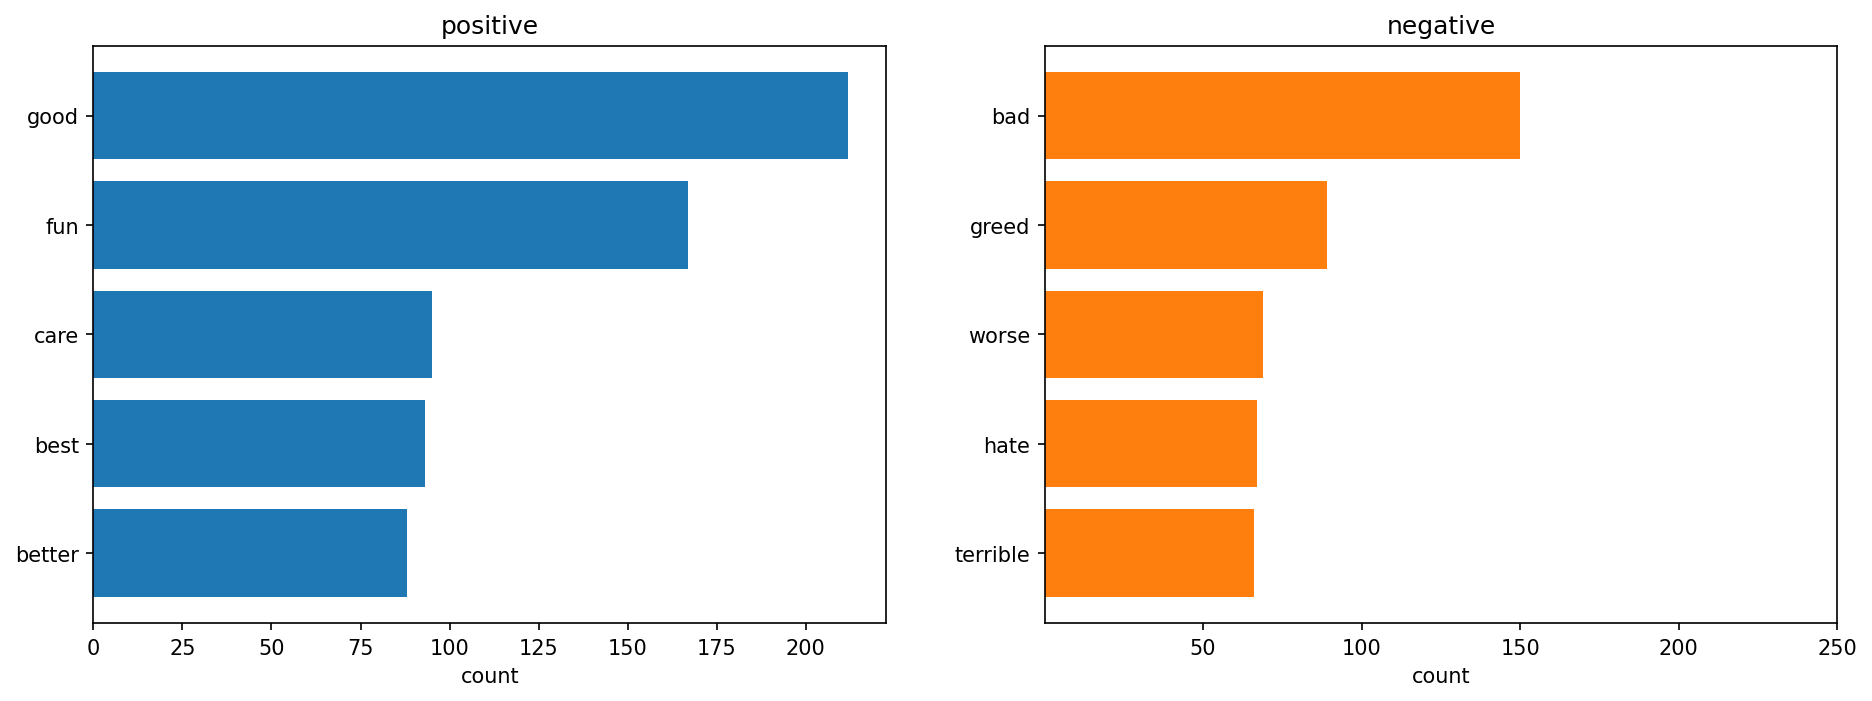

In [41]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175])
ax[1].barh(neg['word'],
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

In [42]:
# 2024-4 正負向情緒代表字

mask = (comment_liwc_df['Month']=='2024-04') & (~comment_liwc_df['sentiments'].isna())
word_count_2404 = comment_liwc_df.loc[mask, ['word','sentiments']]
word_count_2404 = word_count_2404.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_2404.sort_values('size',ascending=False).head(15)

,word,sentiments,size
120,worst,negative,7
39,good,affect,7
40,good,positive,7
119,worst,affect,7
43,hate,affect,6
44,hate,anger,6
45,hate,negative,6
2,bad,affect,5
3,bad,negative,5
63,lost,sad,5


Text(0.5, 0, 'count')

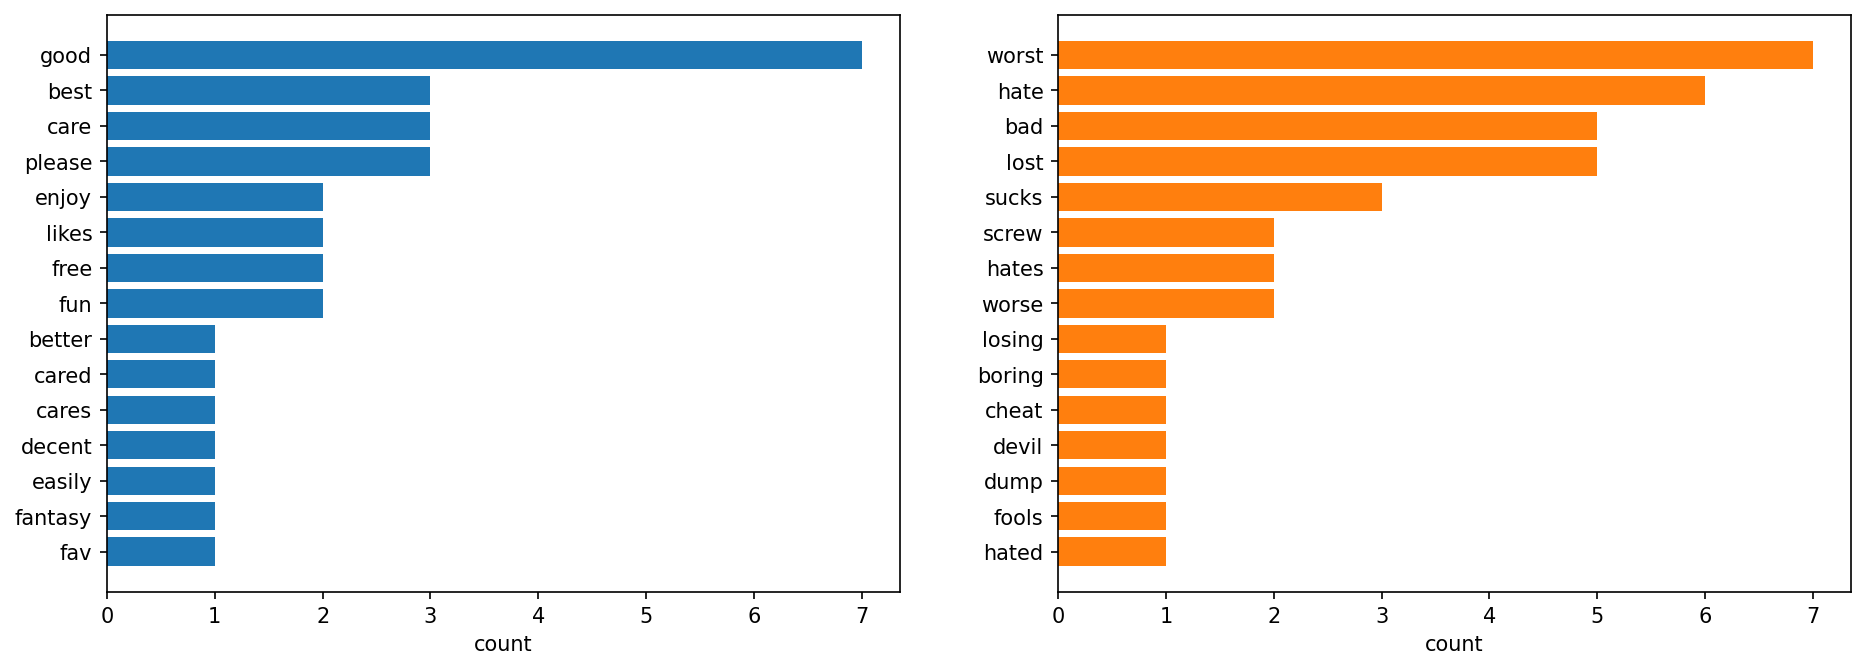

In [43]:
pos = word_count_2404[word_count_2404['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_2404[word_count_2404['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'],
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')

In [44]:
word_count_count = pd.DataFrame(comment_tf_by_ch_df.groupby(['word']).size()).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
25,worst,7
7,hate,6
11,lost,5
1,bad,5
19,sucks,3
15,screw,2
24,worse,2
9,hates,2
23,ugly,1
22,terrible,1


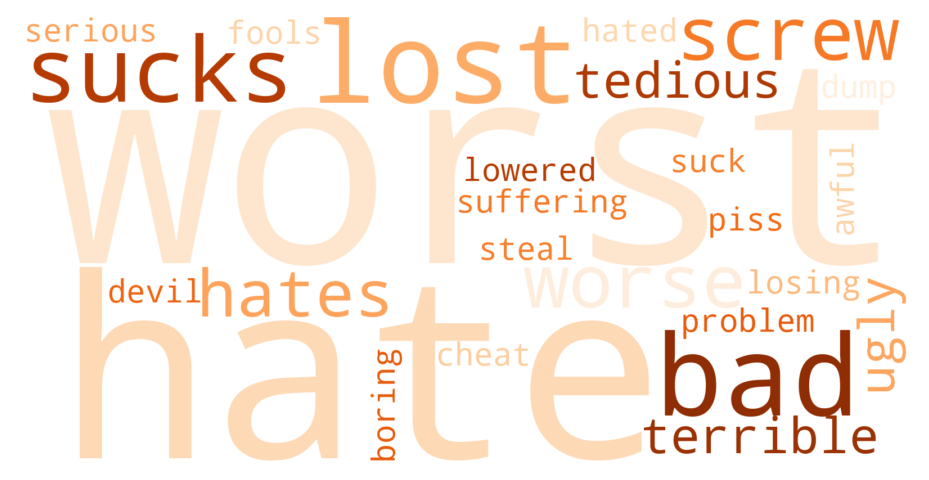

In [45]:
## wordcloud 的 input 是一個 dict, key是 word, value 是次數
cloud = WordCloud(scale = 4, max_words=200, background_color="white", colormap="Oranges")
wc_45 = dict(zip(word_count_count['word'], word_count_count['size']))
cloud.generate_from_frequencies(wc_45)
# 繪圖
# plt.figure(figsize=(10,5), dpi=300)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 進階情緒分析

In [46]:
!pip install stanza

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 660.6 kB/s eta 0:00:02
   - -------------------------------------- 0.0/1.1 MB 495.5 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.1 MB 980.4 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.1 MB 1.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.3/1.1 MB 1.7 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.1 MB 2.2 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.1 MB 2.5 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.1 MB 2.6 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.1 MB 2.6 MB/s eta 0:00:01
   --------------------------------- ------ 0.9/1.1 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   ---------------

In [47]:
import stanza
from stanza.server import CoreNLPClient

import os
import pandas as pd

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords

from wordcloud import WordCloud

import matplotlib.pyplot as plt

c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

2025-03-20 19:35:45 INFO: Installing CoreNLP package into ./stanza_corenlp
2025-03-20 19:36:33 INFO: Downloaded file to ./stanza_corenlp\corenlp.zip
2025-03-20 19:36:34 WARNING: For customized installation location, please set the `CORENLP_HOME` environment variable to the location of the installation. In Unix, this is done with `export CORENLP_HOME=./stanza_corenlp`.


In [54]:
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9999
client = CoreNLPClient(
    # client要處理的項目
    timeout=30000000,
    annotators=['tokenize','ssplit','pos','lemma','ner','entitymentions', 'parse', 'sentiment'],
    memory='24G',
    endpoint='http://localhost:9999',
    # If set to False, the server process will print detailed error logs
    be_quiet=True
)

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(5)

2025-03-20 19:38:46 INFO: Writing properties to tmp file: corenlp_server-a066dac6fee4483d.props
2025-03-20 19:38:46 INFO: Starting server with command: java -Xmx24G -cp ./stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9999 -timeout 30000000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a066dac6fee4483d.props -annotators tokenize,ssplit,pos,lemma,ner,entitymentions,parse,sentiment -preload -outputFormat serialized


##### 拿df的結果測試

In [55]:
# 將要分析的字串傳入client，得到coreNLP的document object
text = for_m134020005_df["Content"][0]
document = client.annotate(text)
print(type(document))

<class 'CoreNLP_pb2.Document'>


In [56]:
# 依序處理每個句子
for i, sent in enumerate(document.sentence):
    # 取得斷句結果：將該句內所有 token 的文字連接起來
    sentence_text = "".join([token.word for token in sent.token])
    print(f"Sentence {i+1} 斷句結果: {sentence_text}")

    # 輸出段詞詳細資訊，依據指定格式印出 token 的 word、lemma、pos 與 ner
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

Sentence 1 斷句結果: 210dollarbattlepassesperseasonTitanfalldiedforthisslop
2           	2           	CD    	MONEY
10          	10          	CD    	MONEY
dollar      	dollar      	NN    	MONEY
battle      	battle      	NN    	O
passes      	pass        	VBZ   	O
per         	per         	IN    	O
season      	season      	NN    	O
Titanfall   	Titanfall   	NNP   	PERSON
died        	die         	VBD   	O
for         	for         	IN    	O
this        	this        	DT    	O
slop        	slop        	NN    	O



在NER的部分，有時候會出現人名、地名是名詞詞組，除了上面用單詞標註的ner，我們可以利用entitymentions把名詞詞組拿出來

In [57]:
for i, sent in enumerate(document.sentence):
    print(f"{'Words':12s}\t{'NER'}\n{'-' * 50}")
    for mention in sent.mentions:
        print(mention.entityMentionText, mention.ner)
    s = ""
    for t in sent.token:
        s = s + t.word + " "
    print(f"sentence{i}: {s}\n")

Words       	NER
--------------------------------------------------
2 10 dollar MONEY
Titanfall PERSON
sentence0: 2 10 dollar battle passes per season Titanfall died for this slop 



In [58]:
test_df = for_m134020005_df.head(50)
test_df

,isRecommended,Content,Date,isUseful,sentence
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...
1,不推薦,"Now with the new battle pass system, I'm delet...",2024-7-8,4345,Now with the new battle pass system Im deletin...
2,不推薦,Game freezes every session i play with the new...,2024-6-27,1174,Game freezes every session i play with the new...
8,不推薦,"Apex is like your neighbor's sister, she treat...",2024-7-18,330,Apex is like your neighbors sister she treats ...
10,不推薦,It's very sad. It's like saying good bye to a ...,2025-1-3,473,Its very sad Its like saying good bye to a lon...
16,不推薦,It was my faivorite game once.. before EA deci...,2025-1-24,213,It was my faivorite game once before EA decide...
17,推薦,Nobody will read my review so I Will Eat 1 Tab...,2024-6-1,1124,Nobody will read my review so I Will Eat 1 Tab...
21,不推薦,Nobody will read my review so i will snort 1 l...,2024-7-25,695,Nobody will read my review so i will snort 1 l...
22,不推薦,Anti-cheat bs,2024-11-6,200,Anticheat bs
26,不推薦,Not anymore. It fell off. Dont buy their overp...,2024-12-16,281,Not anymore It fell off Dont buy their overpri...


In [59]:
doc = client.annotate(text)
doc.sentence[0].sentiment

'Negative'

In [60]:
def sentiment_(text):
    doc = client.annotate(text)
    for sentence in doc.sentence:
        return sentence.sentiment

test_df['sentiment'] = test_df["Content"].apply(sentiment_)
test_df

C:\Users\vince\AppData\Local\Temp\ipykernel_4288\2007507126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sentiment'] = test_df["Content"].apply(sentiment_)


,isRecommended,Content,Date,isUseful,sentence,sentiment
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,Negative
1,不推薦,"Now with the new battle pass system, I'm delet...",2024-7-8,4345,Now with the new battle pass system Im deletin...,Positive
2,不推薦,Game freezes every session i play with the new...,2024-6-27,1174,Game freezes every session i play with the new...,Neutral
8,不推薦,"Apex is like your neighbor's sister, she treat...",2024-7-18,330,Apex is like your neighbors sister she treats ...,Positive
10,不推薦,It's very sad. It's like saying good bye to a ...,2025-1-3,473,Its very sad Its like saying good bye to a lon...,Negative
16,不推薦,It was my faivorite game once.. before EA deci...,2025-1-24,213,It was my faivorite game once before EA decide...,Neutral
17,推薦,Nobody will read my review so I Will Eat 1 Tab...,2024-6-1,1124,Nobody will read my review so I Will Eat 1 Tab...,Neutral
21,不推薦,Nobody will read my review so i will snort 1 l...,2024-7-25,695,Nobody will read my review so i will snort 1 l...,Neutral
22,不推薦,Anti-cheat bs,2024-11-6,200,Anticheat bs,Neutral
26,不推薦,Not anymore. It fell off. Dont buy their overp...,2024-12-16,281,Not anymore It fell off Dont buy their overpri...,Negative


In [61]:
for_m134020005_df['sentiment'] = for_m134020005_df["Content"].apply(sentiment_)
for_m134020005_df

c:\Users\vince\anaconda3\envs\NLP\Lib\site-packages\stanza\protobuf\__init__.py:23: RuntimeWarning: Failed to decode a serialized output from CoreNLP server. An incomplete or empty object will be returned.
  warnings.warn("Failed to decode a serialized output from CoreNLP server. An incomplete or empty object will be returned.", \


,isRecommended,Content,Date,isUseful,sentence,sentiment
0,不推薦,2 10 dollar battle passes per season\n\nTitanf...,2024-7-8,3743,2 10 dollar battle passes per seasonTitanfall ...,Negative
1,不推薦,"Now with the new battle pass system, I'm delet...",2024-7-8,4345,Now with the new battle pass system Im deletin...,Positive
2,不推薦,Game freezes every session i play with the new...,2024-6-27,1174,Game freezes every session i play with the new...,Neutral
8,不推薦,"Apex is like your neighbor's sister, she treat...",2024-7-18,330,Apex is like your neighbors sister she treats ...,Positive
10,不推薦,It's very sad. It's like saying good bye to a ...,2025-1-3,473,Its very sad Its like saying good bye to a lon...,Negative
...,...,...,...,...,...,...
4309,推薦,Game needs new Devs. Slowly losing the communi...,2025-1-24,1,Game needs new Devs Slowly losing the communit...,Neutral
4311,不推薦,I found out I had 115 hours in this game and a...,2025-1-23,1,I found out I had 115 hours in this game and a...,Negative
4312,推薦,GOOD GAME,2025-1-23,1,GOOD GAME,Neutral
4314,不推薦,As pewdiepie once said on a bridge.....,2025-1-22,1,As pewdiepie once said on a bridge,Neutral


In [ ]:
# for_m134020005_df.to_csv("data/corenlp_processed_sentiment.csv")
for_m134020005_df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/corenlp_processed_sentiment.csv")

In [64]:
test_df = for_m134020005_df

In [65]:
# 將日期轉換為 datetime 格式
test_df["Date"] = pd.to_datetime(test_df["Date"])

# 依「年月」與「sentiment」分組，計算筆數
grouped = (
  test_df.groupby([test_df["Date"].dt.strftime("%Y-%m"), "sentiment"])
  .size()
  .reset_index(name="size")
)

# 重新命名欄位，使其與您需要的格式相符
grouped.columns = ["Month", "sentiments", "size"]

# 印出結果
grouped

,Month,sentiments,size
0,2024-03,,1
1,2024-03,Negative,25
2,2024-03,Neutral,45
3,2024-03,Positive,13
4,2024-03,Very negative,2
5,2024-04,Negative,25
6,2024-04,Neutral,38
7,2024-04,Positive,9
8,2024-04,Very negative,3
9,2024-05,Negative,31


C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vince\AppData\Local\Temp\ipykernel_4288\3403948086.py:9: UserWarning: Glyph 24773 (\N{CJK UNIFIE

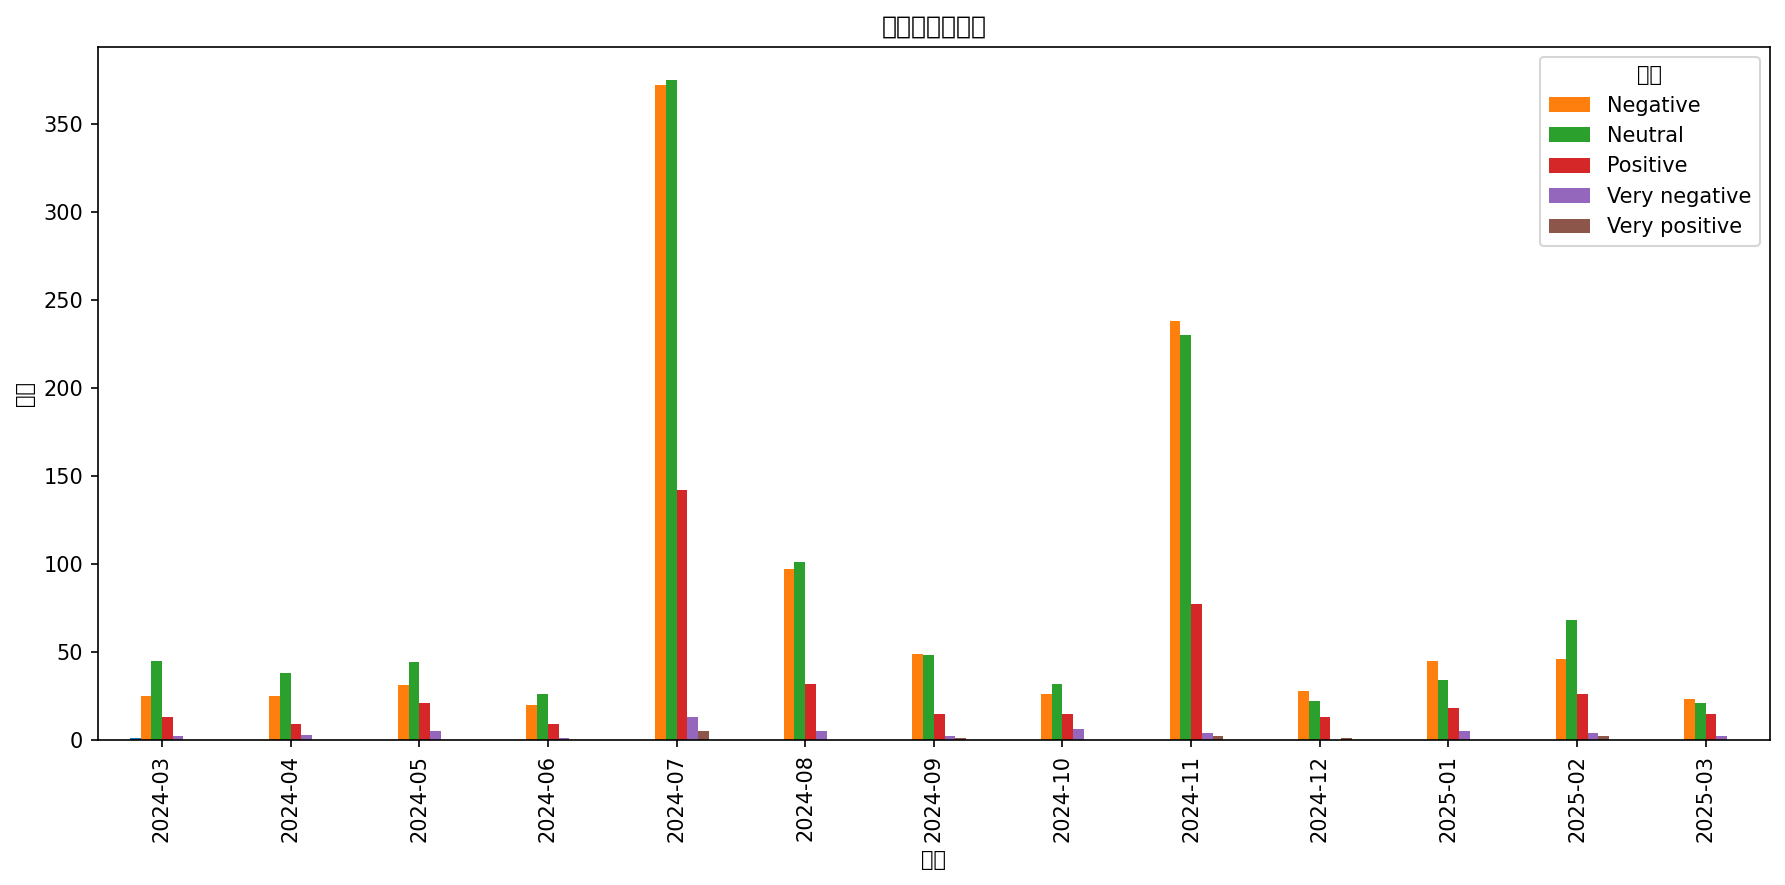

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

df_pivot = grouped.pivot_table(index='Month', columns='sentiments', values='size', aggfunc='sum', fill_value=0)

# 繪製直條圖
df_pivot.plot(kind='bar', figsize=(12, 6))
plt.title("各月份情感分佈")
plt.xlabel("月份")
plt.ylabel("數量")
plt.legend(title="情感")
plt.tight_layout()
plt.show()

In [67]:
client.stop()